In [4]:
import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_tree

In [44]:
plt.style.use('dark_background')

In [ ]:
nltk.download("all")

In [5]:
# Disable scientific notation
pd.set_option('display.float_format', lambda x: '%.9f' % x)
# pd.reset_option('display.float_format')

In [6]:
df = pd.read_csv("train.csv", parse_dates=["DateReported", "DateTimeOfAccident"])

In [7]:
df['ClaimDescription'].value_counts()

ClaimDescription
SLIPPED ON ROLLER TENDONITIS RIGHT SHOULDER                      289
SORTING ALUMINIUM BARS STRAIN SHOULDER NECK                      278
SLIPPED USING LATHE IN EYE CORNEA                                258
REDBACK SPIDER BITE RIGHT FOOT RIGHT FRACTURE                    256
LIFTING TYRES LOWER BACK STRAIN                                  255
                                                                ... 
STRUCK SLICING MACHINE LACERATION INDEX FINGER                     1
STRUCK PIECE METAL BURN RIGHT HAND                                 1
SLIPPED ON FLOOR AND STRUCK HEAD STRAINED NECK                     1
TURNING PALLET PALLET JACK LACERATED RIGHT RING FINGER             1
CUT WITH BREAD KNIFE LACERATION LEFT INDEX AND MIDDLE FINGERS      1
Name: count, Length: 28114, dtype: int64

In [8]:
df.groupby(["ClaimDescription"])["UltimateIncurredClaimCost"].median().sort_values(
    ascending=False
)

ClaimDescription
SLIPPED ON WET FLOOR FRACTURED BASE OF HAND                  4027135.935000000
WHILST MASSAGING FELT PAIN SOFT TISSUE INJURY LEFT HAND       865770.648600000
TABLE TIPPED OVER SOFT TISSUE INJURY RIGHT HAND               823706.301200000
HANDLING BROCOLLI PAIN AND SWELLING LEFT KNEE SOFT TISSUE     525713.324100000
STAPLED FINGER WITH KNIFE STRESS TRAUMA                       516434.166400000
                                                                    ...       
METAL FOREIGN BODY LEFT EYE                                      142.377807900
HIT AGAINST WELDER MACHINE BRUISED ABRASION RIGHT EYE            141.288946600
PARTICLE FELL INTO EYE FOREIGN BODY IN LEFT SHOULDER             134.320349900
PARTICLE IN EYE WHILE GRINDING FOREIGN BODY RIGHT EYE AREA       131.457013000
GLASS INTO EYE FOREIGN BODY LEFT EYE                             124.579660900
Name: UltimateIncurredClaimCost, Length: 28114, dtype: float64

In [9]:
stops = stopwords.words("english")


def text_clean(claim):
    # Converting to Lower Case
    claim = claim.lower()
    # Getting List Of Words
    claim = claim.split()
    # Removing Stop Words(Words which do not add any information like =is,are,I etc)
    claim = [word for word in claim if word not in stops]
    # Stemming the word(words like playing ,played are replaced with play)
    porter_stemmer = PorterStemmer()
    stem_claim = [porter_stemmer.stem(word) for word in claim]

    # Lemmatizing the words (replacing words with their base form)
    lemmatizer = WordNetLemmatizer()
    lem_claim = [lemmatizer.lemmatize(word) for word in claim]
    return lem_claim, stem_claim

In [10]:
df["ClaimDescriptionClean"] = df["ClaimDescription"].apply(
    lambda x: " ".join(text_clean(x)[0])
)

In [11]:
" ".join(text_clean(df["ClaimDescription"][0])[0])

'lifting tyre injury right arm wrist injury'

In [12]:
" ".join(text_clean(df["ClaimDescription"][0])[1])

'lift tyre injuri right arm wrist injuri'

In [13]:
df["ClaimDescriptionClean"][0]

'lifting tyre injury right arm wrist injury'

In [14]:
df['ClaimDescriptionClean'].value_counts()

ClaimDescriptionClean
slipped roller tendonitis right shoulder                   289
sorting aluminium bar strain shoulder neck                 278
slipped using lathe eye cornea                             258
lifting tyre lower back strain                             257
redback spider bite right foot right fracture              256
                                                          ... 
dust blew eye foreign body eye                               1
lifting fertiliser truck torn ligament right ankle           1
clothing caught machine lacerated left index finger          1
truck involved accident fractured rib bruised rib chest      1
cut bread knife laceration left index middle finger          1
Name: count, Length: 27788, dtype: int64

In [15]:
len(df['ClaimDescriptionClean'].unique())

27788

In [16]:
corpus = df['ClaimDescriptionClean']
list_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))

In [36]:
len(list_tokens)

345273

In [22]:
# Tokenize the claim descriptions
tokenized_descriptions = [claim.split() for claim in df["ClaimDescription"]]

# Train a Word2Vec model
model = Word2Vec(
    tokenized_descriptions, min_count=1, vector_size=100, workers=4
)  # Adjust vector_size as needed


# Create embeddings for each claim
def create_embedding(claim):
    words = claim.split()
    embeddings = [model.wv[word] for word in words if word in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)


In [23]:
create_embedding(df["ClaimDescriptionClean"][3])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [24]:
print(df["ClaimDescriptionClean"][3])

digging lower back lower back strain


In [25]:
print(len(model.wv.key_to_index))
print(list(model.wv.key_to_index.keys())[:10])

3728
['RIGHT', 'LEFT', 'BACK', 'STRAIN', 'LOWER', 'AND', 'FINGER', 'LIFTING', 'HAND', 'STRUCK']


In [26]:
sample_word = list(model.wv.key_to_index.keys())[0]
print(f"Sample word: {sample_word}")
print(model.wv[sample_word])

Sample word: RIGHT
[-0.10175563  0.6583534   0.95527285  0.7208346  -0.2041652  -0.30136552
  0.76158476  0.9332118  -1.7549609   0.2375708  -0.11861525 -0.85763395
 -0.4353855   0.2118297  -0.33718163  0.6005928   0.32347652  0.7010614
  0.28350136 -0.46172208 -0.47924986 -0.1422837   0.52645344 -0.15748855
  0.18470347 -0.08344705 -0.47350228 -0.3045136  -0.3412887  -0.74656785
 -0.32685605 -0.07933708  0.50927955 -0.01561446 -0.6690312  -0.4027261
  0.52763385  0.07233383  0.5313693   0.01806948 -0.82588917  0.10389394
 -1.0427263   0.03756323 -0.41006368  0.2267026   0.28285652  0.4519796
  0.06871233  0.60144454  0.41071334  0.75302297 -0.00496789  0.60424715
  0.7083918   0.19981773  0.86145145  0.07523016 -0.34319252  0.92803127
 -1.3560705  -0.08140198 -0.54078484 -0.74592376 -0.16427861 -0.24456559
 -0.24518888 -0.796158    0.8186502   0.67535347 -0.41523224  0.4979192
  0.308267   -0.41160345  0.48634443  0.41881144 -0.3536651   0.5056039
 -0.38932624 -0.27368408  0.13566524 

In [27]:
def create_embedding(claim):
    words = claim.split()
    print(f"Words in claim: {words}")
    embeddings = []
    for word in words:
        if word in model.wv:
            embeddings.append(model.wv[word])
        else:
            print(f"Word not in vocabulary: {word}")
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        print("No words found in vocabulary")
        return np.zeros(model.vector_size)

# Test the function
result = create_embedding(df["ClaimDescriptionClean"][3])
print("Resulting embedding:", result)

Words in claim: ['digging', 'lower', 'back', 'lower', 'back', 'strain']
Word not in vocabulary: digging
Word not in vocabulary: lower
Word not in vocabulary: back
Word not in vocabulary: lower
Word not in vocabulary: back
Word not in vocabulary: strain
No words found in vocabulary
Resulting embedding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [28]:
print("Number of documents:", len(tokenized_descriptions))
print("First few documents:")
for doc in tokenized_descriptions[:5]:
    print(doc)

Number of documents: 54000
First few documents:
['LIFTING', 'TYRE', 'INJURY', 'TO', 'RIGHT', 'ARM', 'AND', 'WRIST', 'INJURY']
['STEPPED', 'AROUND', 'CRATES', 'AND', 'TRUCK', 'TRAY', 'FRACTURE', 'LEFT', 'FOREARM']
['CUT', 'ON', 'SHARP', 'EDGE', 'CUT', 'LEFT', 'THUMB']
['DIGGING', 'LOWER', 'BACK', 'LOWER', 'BACK', 'STRAIN']
['REACHING', 'ABOVE', 'SHOULDER', 'LEVEL', 'ACUTE', 'MUSCLE', 'STRAIN', 'LEFT', 'SIDE', 'OF', 'STOMACH']


In [29]:
print("Vocabulary size:", len(model.wv.key_to_index))
print("First 20 words in vocabulary:", list(model.wv.key_to_index.keys())[:20])

Vocabulary size: 3728
First 20 words in vocabulary: ['RIGHT', 'LEFT', 'BACK', 'STRAIN', 'LOWER', 'AND', 'FINGER', 'LIFTING', 'HAND', 'STRUCK', 'SHOULDER', 'FELL', 'SLIPPED', 'LACERATION', 'EYE', 'KNEE', 'LACERATED', 'ON', 'INJURY', 'STRAINED']


In [30]:
# Ensure tokenized_descriptions is correct
tokenized_descriptions = [claim.split() for claim in df["ClaimDescriptionClean"]]

# Train the Word2Vec model
model = Word2Vec(sentences=tokenized_descriptions, vector_size=100, window=5, min_count=1, workers=4)

# Check the vocabulary size again
print("Vocabulary size after retraining:", len(model.wv.key_to_index))

# Test the embedding function again
def create_embedding(claim):
    words = claim.split()
    embeddings = [model.wv[word] for word in words if word in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

# Test on the same claim as before
result = create_embedding(df["ClaimDescriptionClean"][3])
print("Resulting embedding:", result)
print("Is the embedding non-zero?", np.any(result != 0))

Vocabulary size after retraining: 3266
Resulting embedding: [-1.0359119   0.18308967 -0.27562025 -0.27010843  0.01433389  0.32292718
 -0.44161847  1.1572279   0.00411253 -0.4153541   0.02969339 -0.98321337
  0.49790058 -0.15149489  0.00603051 -0.5391729   0.31317052 -0.30870354
 -0.41747975 -0.62126434 -0.31148735 -0.3890355   0.4376317   0.6981385
 -0.20732255  0.0579293   0.5403396  -0.20927645 -0.18629877  0.34561244
  0.30461514 -0.23396893 -0.32734206 -1.0712107   0.05818431  0.09277325
  0.18221919 -0.6712653  -0.16063459  0.5639011   0.3649778   0.22489762
 -0.32188717 -0.07146738  0.693151   -0.6176775   0.03500528  0.04921145
  0.07762853 -0.46086755  0.5747488  -0.11274669  0.1942095  -0.7648523
 -0.3594943  -1.0433583   0.01900984 -0.6914578   0.02898107  0.10880703
  0.35397694 -0.42269742  0.6009862   0.21829133 -0.5208097   0.11369121
  0.34343454  0.63558143 -0.17981929  0.37399217  0.5637087   0.33639026
  0.04915248  0.18770261  0.47261032  0.19964387  0.5784487   0.01

In [31]:
print("First few cleaned claim descriptions:")
print(df["ClaimDescriptionClean"].head())

# Check for empty strings or NaN values
print("\nNumber of empty strings:", (df["ClaimDescriptionClean"] == "").sum())
print("Number of NaN values:", df["ClaimDescriptionClean"].isna().sum())

First few cleaned claim descriptions:
0           lifting tyre injury right arm wrist injury
1    stepped around crate truck tray fracture left ...
2                        cut sharp edge cut left thumb
3                 digging lower back lower back strain
4    reaching shoulder level acute muscle strain le...
Name: ClaimDescriptionClean, dtype: object

Number of empty strings: 0
Number of NaN values: 0


In [32]:
# Remove empty strings and NaN values
df = df.dropna(subset=["ClaimDescriptionClean"])
df = df[df["ClaimDescriptionClean"] != ""]

# Retokenize and retrain
tokenized_descriptions = [claim.split() for claim in df["ClaimDescriptionClean"]]
model = Word2Vec(sentences=tokenized_descriptions, vector_size=100, window=5, min_count=1, workers=4)

print("Vocabulary size after cleaning and retraining:", len(model.wv.key_to_index))

Vocabulary size after cleaning and retraining: 3266


In [33]:
# Test the function
result = create_embedding(df["ClaimDescriptionClean"][3])
print("Resulting embedding:", result)

Resulting embedding: [-0.9775627   0.44275543 -0.41284    -0.40897802 -0.06790375  0.30826783
 -0.4242669   1.1426544   0.05456142 -0.34557506  0.0488385  -1.1742885
  0.47741154 -0.07982513 -0.03417675 -0.52236414  0.26898977 -0.21490087
 -0.49601355 -0.8770266  -0.23530643 -0.33347666  0.40375614  0.58532083
 -0.35747135  0.06902069  0.45795214 -0.20836042 -0.21519987  0.2960032
  0.2575599  -0.30068287 -0.21617036 -1.0745366   0.04065526  0.10200892
  0.29649356 -0.355785   -0.15336286  0.78445244  0.3669368   0.25044766
 -0.2948297  -0.03704479  0.569672   -0.42191538 -0.0492241   0.1857587
 -0.00294836 -0.49671838  0.80180573 -0.06550356  0.3834528  -0.78904986
 -0.38627434 -0.8325042   0.20872398 -0.5558143   0.17717378 -0.1198346
  0.3426019  -0.42826006  0.6677335   0.3154473  -0.48607585  0.20685141
  0.44175252  0.5636508  -0.21016036  0.20216697  0.5540908   0.33905467
  0.20184489  0.28897095  0.4661868   0.14651869  0.5125006   0.04848874
  0.0423799   0.15922861 -0.234859

In [39]:
df["ClaimDescriptionEmbedding"] = df["ClaimDescriptionClean"].apply(create_embedding)

In [40]:
df["ClaimDescriptionEmbedding"][3]

array([-0.9775627 ,  0.44275543, -0.41284   , -0.40897802, -0.06790375,
        0.30826783, -0.4242669 ,  1.1426544 ,  0.05456142, -0.34557506,
        0.0488385 , -1.1742885 ,  0.47741154, -0.07982513, -0.03417675,
       -0.52236414,  0.26898977, -0.21490087, -0.49601355, -0.8770266 ,
       -0.23530643, -0.33347666,  0.40375614,  0.58532083, -0.35747135,
        0.06902069,  0.45795214, -0.20836042, -0.21519987,  0.2960032 ,
        0.2575599 , -0.30068287, -0.21617036, -1.0745366 ,  0.04065526,
        0.10200892,  0.29649356, -0.355785  , -0.15336286,  0.78445244,
        0.3669368 ,  0.25044766, -0.2948297 , -0.03704479,  0.569672  ,
       -0.42191538, -0.0492241 ,  0.1857587 , -0.00294836, -0.49671838,
        0.80180573, -0.06550356,  0.3834528 , -0.78904986, -0.38627434,
       -0.8325042 ,  0.20872398, -0.5558143 ,  0.17717378, -0.1198346 ,
        0.3426019 , -0.42826006,  0.6677335 ,  0.3154473 , -0.48607585,
        0.20685141,  0.44175252,  0.5636508 , -0.21016036,  0.20

In [41]:
from sklearn.metrics.pairwise import cosine_similarity

def compare_claims(claim1_embedding, claim2_embedding):
    similarity = cosine_similarity([claim1_embedding], [claim2_embedding])[0][0]
    return similarity

# Example usage
claim1_embedding = create_embedding(df["ClaimDescriptionClean"][0])
claim2_embedding = create_embedding(df["ClaimDescriptionClean"][1])

similarity = compare_claims(claim1_embedding, claim2_embedding)
print(f"Similarity between claim 1 and claim 2: {similarity}")

Similarity between claim 1 and claim 2: 0.6775350570678711


In [42]:
from sklearn.cluster import KMeans

# Create embeddings for all claims
all_embeddings = np.array([create_embedding(claim) for claim in df["ClaimDescriptionClean"]])

# Perform K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(all_embeddings)

# Add cluster labels to the dataframe
df["ClusterLabel"] = cluster_labels

# View some claims from each cluster
for cluster in range(5):
    print(f"\nCluster {cluster} claims:")
    print(df[df["ClusterLabel"] == cluster]["ClaimDescriptionClean"].head(3))


Cluster 0 claims:
9     struck pine dust abrasion left eye irritation
14          emptying bin fish bone foreign body eye
42       struck dust grinding foreign body left eye
Name: ClaimDescriptionClean, dtype: object

Cluster 1 claims:
3              digging lower back lower back strain
10    strained muscle back strained lower back pain
12                              picking parcel back
Name: ClaimDescriptionClean, dtype: object

Cluster 2 claims:
0           lifting tyre injury right arm wrist injury
1    stepped around crate truck tray fracture left ...
4    reaching shoulder level acute muscle strain le...
Name: ClaimDescriptionClean, dtype: object

Cluster 3 claims:
2                        cut sharp edge cut left thumb
5                      struck head head lacerated head
8    jack slipped catching finger cut left little f...
Name: ClaimDescriptionClean, dtype: object

Cluster 4 claims:
106             car accident truck car accident
208    motor vehicle accident whiplash abra

In [47]:
df.columns

Index(['ClaimNumber', 'DateTimeOfAccident', 'DateReported', 'Age', 'Gender',
       'MaritalStatus', 'DependentChildren', 'DependentsOther', 'WeeklyWages',
       'PartTimeFullTime', 'HoursWorkedPerWeek', 'DaysWorkedPerWeek',
       'ClaimDescription', 'InitialIncurredCalimsCost',
       'UltimateIncurredClaimCost', 'ClaimDescriptionClean',
       'ClaimDescriptionEmbedding', 'ClusterLabel'],
      dtype='object')

In [46]:
df["ClusterLabel"]

0        2
1        2
2        3
3        1
4        2
        ..
53995    3
53996    2
53997    3
53998    3
53999    3
Name: ClusterLabel, Length: 54000, dtype: int32

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_claims(target_claim, n=5):
    target_embedding = create_embedding(target_claim)
    all_embeddings = np.array([create_embedding(claim) for claim in df["ClaimDescriptionClean"]])
    
    similarities = cosine_similarity([target_embedding], all_embeddings)[0]
    top_indices = similarities.argsort()[-n:][::-1]
    
    return df.iloc[top_indices][["ClaimDescriptionClean"]]

# Example usage
target_claim = df["ClaimDescriptionClean"][0]
similar_claims = find_similar_claims(target_claim)
print("Target claim:", target_claim)
print("\nSimilar claims:")
print(similar_claims)

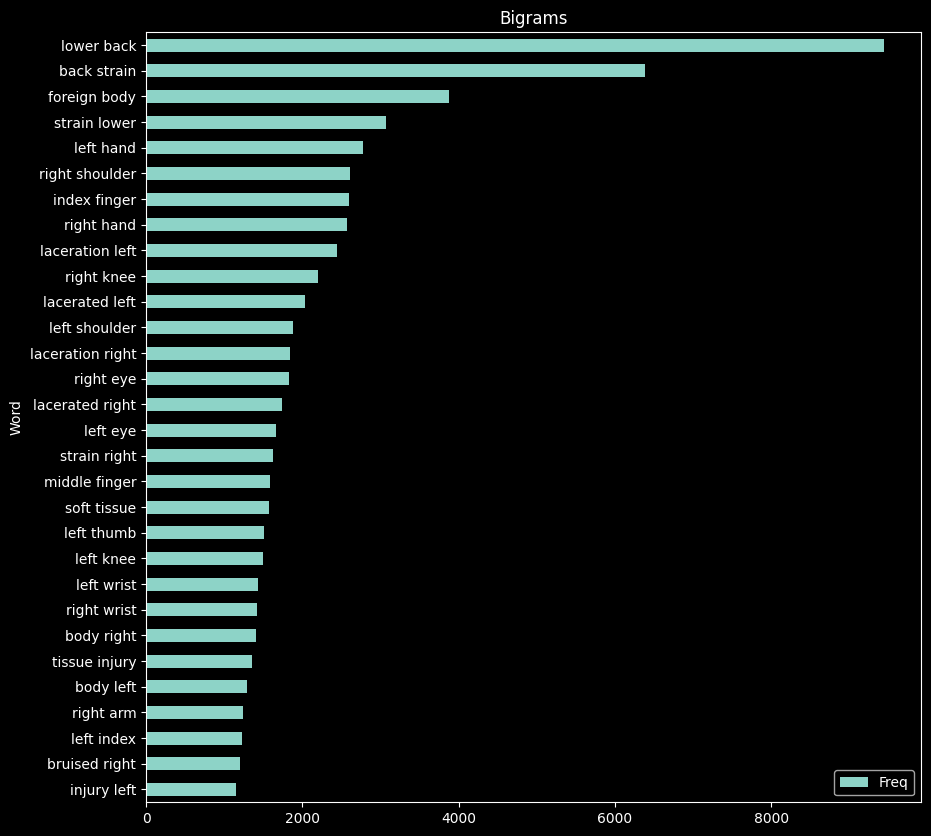

In [45]:
#Most common pairs of words that occur together in Claim Description

plt.figsize=((25,30))
dic_words_freq = nltk.FreqDist(nltk.ngrams(list_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:30,:].sort_values(by="Freq").plot(kind="barh",figsize=(10,10))
plt.title('Bigrams')
                  
plt.show()